In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import numpy as np
import math

import OSS as oss
import BPD as bpd
import accumulate as acc
import plotters

### Step 1: OSS

In [2]:
filepath = "ballroom.wav"
sr, data = oss.read_wav(filepath)
print(f"sampling rate: {sr}Hz")
print(f"audio length: {round(len(data)/sr, 3)} seconds")
#plot_signal(data=data, sr=sr, stop=6, title="Raw Signal")

sampling rate: 44100Hz
audio length: 31.788 seconds


calculated frame count: 10944 frames
returned frame count: 10944 frames
(10944, 1024)


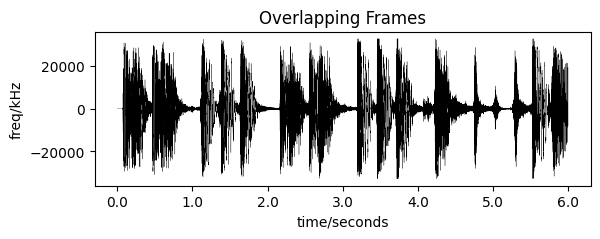

In [3]:
framesize = 1024
hop = 128
print(f"calculated frame count: {1+math.floor((len(data)-framesize)/hop)} frames")
frames = oss.get_frames(data=data, framesize=framesize, hop=hop)
print(f"returned frame count: {len(frames)} frames")
frames6 = frames[:2059]
print(frames.shape)
plotters.plot_frames(frames=frames6, sr=44100, framesize=1024, hop=128, title="Overlapping Frames")

In [4]:
tappered_frames = oss.hamming_window(frames)
tappered_frames6 = oss.hamming_window(frames6)
# compute the discrete fourier transform of the frames
fft_frames = scipy.fft.fft(tappered_frames)
fft_frames6 = scipy.fft.fft(tappered_frames6)

In [5]:
log_power = np.array(oss.comp_log_power(fft_frames))
log_power6 = np.array(oss.comp_log_power(fft_frames6))

In [6]:
print(fft_frames.shape)
print(fft_frames6.shape)
print(log_power.shape)
print(log_power6.shape)

(10944, 1024)
(2059, 1024)
(10944, 1024)
(2059, 1024)


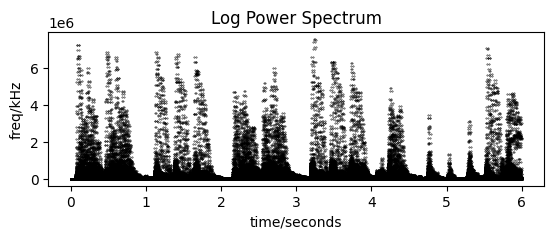

In [7]:
plotters.plot_log_spectrum(fft_frames6, framesize=1024, hop=128, sr=44100)

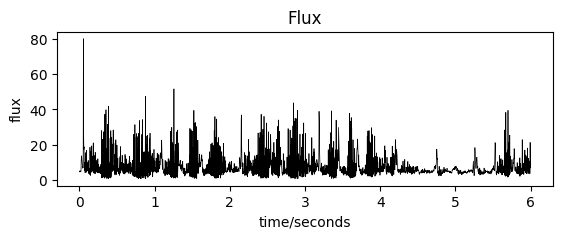

In [8]:
flux = oss.get_flux(log_power, fft_frames)
flux6 = oss.get_flux(log_power6, fft_frames6)
plotters.plot_flux(flux6)

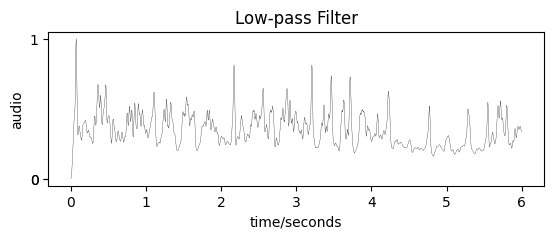

In [9]:
filtered_signal = oss.low_pass_filter(flux=flux)
filtered_signal6 = oss.low_pass_filter(flux=flux6)
plotters.plot_signal(filtered_signal6, sr=344.5, title="Low-pass Filter")

### Step 2: Beat Period Detection

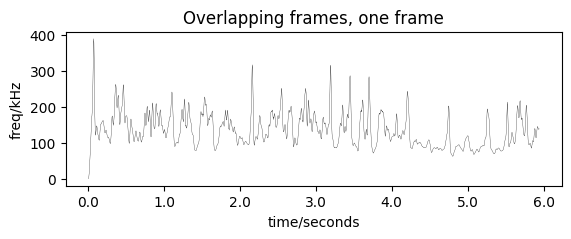

In [10]:
frames = bpd.overlap(data=filtered_signal, framesize=2048, hop=128)
plotters.plot_frames(frames=frames[0], sr=344.5, framesize=2048, hop=128, title="Overlapping frames, one frame")

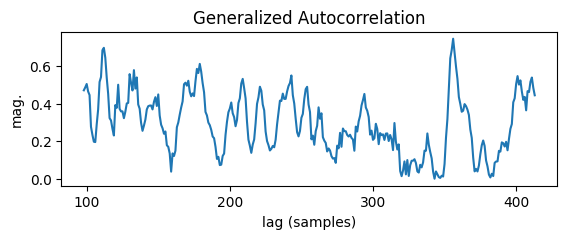

In [11]:
A = bpd.generalized_autocorrelation(frames=frames, c=0.5)
plotters.plot_correlation(A=A[0], title="Generalized Autocorrelation")

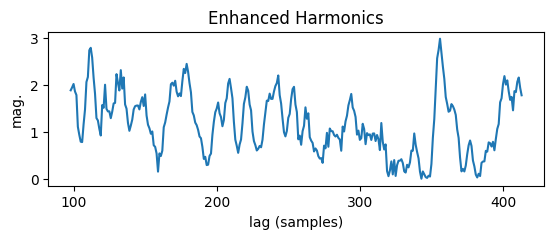

In [12]:
EAC = bpd.enhance_harmonics(A=abs(A))
plotters.plot_correlation(A=EAC[0], title="Enhanced Harmonics")

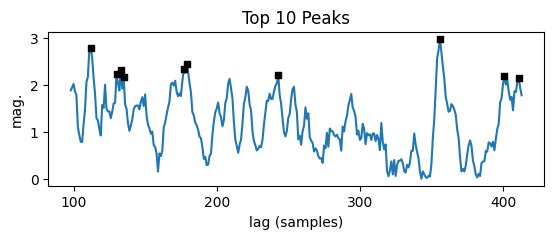

In [13]:
indices, values = bpd.pick_peaks(EAC)
idx = 0
plotters.plot_correlation(A=EAC[0], start=98+316*idx, stop=414+316*idx, indices=indices[idx], values=values[idx], title="Top 10 Peaks")

In [14]:
Lm = bpd.evaluate_pulse_train(indices[0], frames[0])
print(f"{int(round(344.5*60/Lm, 0))} bpm")

66 bpm


### Step 3: Accumulation and overall estimate

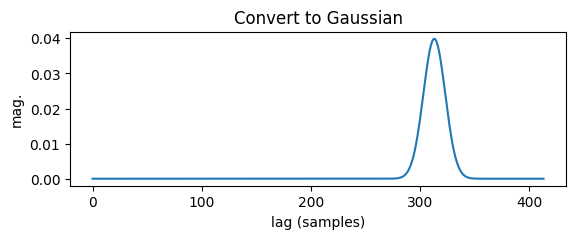

In [15]:
plotters.plot_gaussian(Lm=Lm, g=acc.Gm, title="Convert to Gaussian")

149 bpm


c:\Users\hitts\Dropbox\PC\Documents\GitHub\beat\src\BPD.py:76: RuntimeWarning: invalid value encountered in divide
  return SCv/np.linalg.norm(SCv), SCx/np.linalg.norm(SCx)


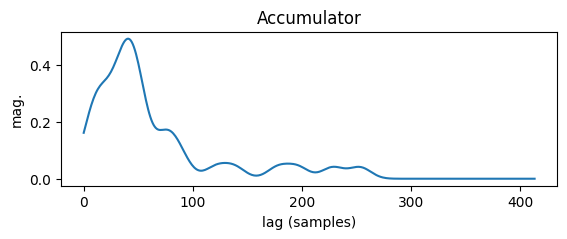

In [26]:
Lms = acc.eval_entire_signal(indices, frames)
y = acc.accumulate_gauss(Lms=Lms)
idxs, _ = bpd.find_local_maximums(y)
print(f"{int(round(344.5*60/(idxs[-1]+98), 0))} bpm")
plotters.plot_gaussian(Lm=y, g=acc.Gm, title="Accumulator")